In [2]:
import numpy as np
import pandas as pd
from time import time
from nltk.tokenize import word_tokenize
import warnings
import string
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score, silhouette_samples, classification_report, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

plt.rcParams["image.cmap"] = "Paired"

In [3]:
raw_data = pd.read_csv("train.csv")
raw_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
raw_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
df = raw_data.drop(columns=['location'])
df.head()

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
import contractions
import string

def clean_tweet(text):

    # Remove_HTMLs
    new_text = re.sub(r'<.*?>',"", text)

    # Expand_Contractions
    expanded_words = []   
    for word in new_text.split():
        # using contractions.fix to expand the shortened words
        expanded_words.append(contractions.fix(word))  
   
    new_text = ' '.join(expanded_words)

    # Remove_URLs
    new_text = re.sub(r'https?://(www\.)?(\w+)(\.\w+)(/\w*)?',"", new_text)

    # Remove_Email_IDs
    new_text = re.sub(r'[\w\.-]+@[\w\.-]+\.\w+',"", new_text)
    
    # Remove_emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    new_text = emoji_pattern.sub(r'', new_text)

    # Remove_Tweeter_Mentions_Chars
    new_text = re.sub(r'@\w+',"", new_text)

    # Abbreviation/Acronym_Disambiguation
    new_text = re.sub(r"MH370", "Malaysia Airlines Flight 370", new_text)
    new_text = re.sub(r"mÌ¼sica", "music", new_text)
    new_text = re.sub(r"okwx", "Oklahoma City Weather", new_text)
    new_text = re.sub(r"arwx", "Arkansas Weather", new_text)    
    new_text = re.sub(r"gawx", "Georgia Weather", new_text)  
    new_text = re.sub(r"scwx", "South Carolina Weather", new_text)  
    new_text = re.sub(r"cawx", "California Weather", new_text)
    new_text = re.sub(r"tnwx", "Tennessee Weather", new_text)
    new_text = re.sub(r"azwx", "Arizona Weather", new_text)  
    new_text = re.sub(r"alwx", "Alabama Weather", new_text)
    new_text = re.sub(r"wordpressdotcom", "wordpress", new_text)    
    new_text = re.sub(r"usNWSgov", "United States National Weather Service", new_text)
    new_text = re.sub(r"Suruc", "Sanliurfa", new_text)

    new_text = re.sub(r"&gt;", ">", new_text)
    new_text = re.sub(r"&lt;", "<", new_text)
    new_text = re.sub(r"&amp;", "&", new_text)

    # Remove_Unicode_Characters
    new_text = new_text.encode("ascii", "ignore").decode()

    # Remove_Punctuations
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        new_text = re.sub(re.escape(p), " ",new_text)

    # Remove_Digits
    new_text = re.sub(r'\w*\d+\w*', "",new_text)

    # Lower_case
    new_text = new_text.lower()
    
    return new_text

In [8]:
df['cleaned_text'] = df['text'].apply(clean_tweet)
for tweet, cleaned_tweet in zip(df['text'].tail(), df['cleaned_text'].tail()):
  print(f'Original tweet: {tweet}')
  print(f'Cleaned tweet: {cleaned_tweet}\n-')

Original tweet: Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5
Cleaned tweet: two giant cranes holding a bridge collapse into nearby homes 
-
Original tweet: @aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.
Cleaned tweet:   the out of control wild fires in california even in the northern part of the state  very troubling 
-
Original tweet: M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ
Cleaned tweet:      utc   s of volcano hawaii  
-
Original tweet: Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.
Cleaned tweet: police investigating after an e bike collided with a car in little portugal  e bike rider suffered serious non life threatening injuries 
-
Original tweet: The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d
Cleaned 

In [9]:
import transformers
import torch

# Instantiate the BERT tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

# Instantiate the BERT model
model = transformers.BertModel.from_pretrained('bert-base-uncased')
def extract_keywords(text):
    tokens = tokenizer.encode(text, add_special_tokens=True)
    if len(tokens) == 0:
        return []
    input_ids = torch.tensor([tokens])
    with torch.no_grad():
        outputs = model(input_ids)
        embeddings = outputs.last_hidden_state[0]
    sentence_embedding = torch.sum(embeddings, dim=0)
    if len(sentence_embedding) < 3:
        # return fewer than 3 keywords if there aren't enough embeddings
        num_keywords = len(sentence_embedding)
    else:
        num_keywords = 3
    keywords = []
    for i in sentence_embedding.argsort()[-num_keywords:]:
        if i >= len(tokens):
            continue
        keywords.append(tokenizer.decode(tokens[i]))
    return keywords[::-1]

# Fill in the missing values in the "keyword" column using BERT
for i in range(len(df)):
    if pd.isnull(df.loc[i, 'keyword']):
        keywords = extract_keywords(df.loc[i, 'cleaned_text'])
        df.loc[i, 'keyword'] = ', '.join(keywords)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
df.iloc[9:14]

,id,keyword,text,target,cleaned_text
9,15,i s,I'm afraid that the tornado is coming to our a...,1,i am afraid that the tornado is coming to our ...
10,16,,Three people died from the heat wave so far,1,three people died from the heat wave so far
11,17,,Haha South Tampa is getting flooded hah- WAIT ...,1,haha south tampa is getting flooded hah wait ...
12,18,o r,#raining #flooding #Florida #TampaBay #Tampa 1...,1,raining flooding florida tampabay tampa ...
13,19,a r r i v e d,#Flood in Bago Myanmar #We arrived Bago,1,flood in bago myanmar we arrived bago


In [11]:
df.isnull().sum()

id              0
keyword         0
text            0
target          0
cleaned_text    0
dtype: int64

0    4342
1    3271
Name: target, dtype: int64


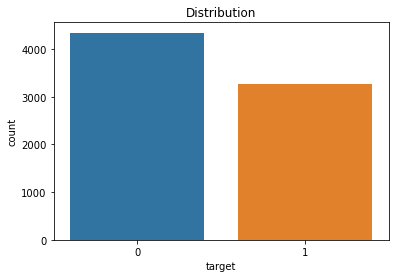

In [12]:
#Visualization of the frequency distribution of the 'target' variable
sns.countplot(x = 'target', data = df)
plt.title('Distribution');

print(df['target'].value_counts())

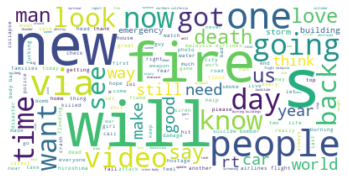

In [13]:
#The creation of word clouds - visual representations of text data 
#in which the size of each word corresponds to its frequency in the input text.

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

# Combine all tweets into a single string
text = " ".join(tweet for tweet in df.cleaned_text)

# Create and generate a word cloud image
wordcloud = WordCloud(max_font_size=80, max_words=160, background_color="white").generate(text)

# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [14]:
train_size = int(0.8 * df.shape[0])

train_index = [x for x in range(0, train_size)]
test_index = [x for x in range(train_size, df.shape[0])]

X_train = df.loc[train_index, 'cleaned_text']
y_train = df.loc[train_index, 'target']

X_test = df.loc[test_index, 'cleaned_text']
y_test = df.loc[test_index, 'target']

print(f"Training set shape: {X_train.shape}")
print(f"Training label shape: {y_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Test label shape: {y_test.shape}")

Training set shape: (6090,)
Training label shape: (6090,)
Test set shape: (1523,)
Test label shape: (1523,)


In [15]:
# TF-IDF Vectorization
max_features = None

vectorizer = TfidfVectorizer(max_features = max_features)

# Fitting vectorizer to training set vocabulary
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transforming the test set
X_test_tfidf = vectorizer.transform(X_test)

print(f"TF-IDF normalized training set shape: {X_train_tfidf.shape}")
print(f"TF-IDF normalized test set shape: {X_test_tfidf.shape}")

TF-IDF normalized training set shape: (6090, 12232)
TF-IDF normalized test set shape: (1523, 12232)


In [16]:
# Singular Value Decomposition with Numpy SVD
U, S, VT = np.linalg.svd(X_train_tfidf.toarray(), full_matrices=0)

# Optimal Hard Thresholding (Gavish and Donoho, 2014)
def omega_approx(X):
    """
    Return an approximate omega value for given matrix X. Equation (5) from
    Gavish and Donoho, 2014.
    """
    beta = min(X.shape) / max(X.shape)
    omega = 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43
    return omega

# Defining singular value hard threshold
def svht(X, sv = None):
    """
    Return the optimal singular value hard threshold (SVHT) value.
    `X` is any m-by-n matrix. `sigma` is the standard deviation of the 
    noise, if known. Optionally supply the vector of singular values `sv`
    for the matrix (only necessary when `sigma` is unknown). If `sigma`
    is unknown and `sv` is not supplied, then the method automatically
    computes the singular values.
    """
    sv = np.squeeze(sv)
    if sv.ndim != 1:
        raise ValueError('vector of singular values must be 1-dimensional')
    return np.median(sv) * omega_approx(X)

cutoff = svht(X_train_tfidf.toarray(), sv = S) # Hard threshold
r_opt = np.max(np.where(S > cutoff)) # Keep modes w/ sig > cutoff 

print(f"Optimum number of eigen values: {r_opt}")

Optimum number of eigen values: 645


In [17]:
# Singular Value Decomposition to reduce dimensionality truncated at optimum hard threshold
svd = TruncatedSVD(n_components = r_opt, random_state = 123)

# Standard normalization for spherical K-Means clustering
normalizer = Normalizer(copy = True)

# Latent Semantic Analysis dimensionality reduction pipeline
lsa = make_pipeline(svd, normalizer)

X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.transform(X_test_tfidf)

explained_variance = svd.explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {explained_variance * 100:.2f}%")

print(f"LSA training set shape: {X_train_lsa.shape}")
print(f"LSA test set shape: {X_test_lsa.shape}")

Explained variance of the SVD step: 54.80%
LSA training set shape: (6090, 645)
LSA test set shape: (1523, 645)


In [18]:
def evaluate(X_train, y_train, X_test, classif_report = True):
  '''
  Plot classification report for given training set using Logistic Regression
  and Multinomial Naive Bayes classifiers.
  '''
  log_r = LogisticRegression()
  log_r.fit(X_train, y_train)
  y_pred_log_r = log_r.predict(X_test)

  m_nb = MultinomialNB()
  m_nb.fit(X_train, y_train)
  y_pred_m_nb = m_nb.predict(X_test)

  if classif_report:
      print('Logistic Regression classification report: \n',
            classification_report(y_test, y_pred_log_r, digits = 3),
            '\n=====================================================\n')

      print('Multinomial Naive Bayes classification report: \n',
            classification_report(y_test, y_pred_m_nb, digits = 3))
  
  log_r_f1 = f1_score(y_test, y_pred_log_r)
  log_r_acc = accuracy_score(y_test, y_pred_log_r)

  m_nb_f1 = f1_score(y_test, y_pred_m_nb)
  m_nb_acc = accuracy_score(y_test, y_pred_m_nb)

  return log_r_f1, log_r_acc, m_nb_f1, m_nb_acc

In [34]:
# Evaluating performance with a reduced training set
n_labeled = 300
evaluate(X_train_tfidf[:n_labeled], y_train[:n_labeled], X_test_tfidf)

Logistic Regression classification report: 
               precision    recall  f1-score   support

           0      0.537     1.000     0.699       814
           1      1.000     0.010     0.020       709

    accuracy                          0.539      1523
   macro avg      0.768     0.505     0.359      1523
weighted avg      0.753     0.539     0.383      1523
 

Multinomial Naive Bayes classification report: 
               precision    recall  f1-score   support

           0      0.564     0.988     0.718       814
           1      0.898     0.124     0.218       709

    accuracy                          0.586      1523
   macro avg      0.731     0.556     0.468      1523
weighted avg      0.720     0.586     0.485      1523



(0.019553072625698324,
 0.5390676296782666,
 0.21809169764560102,
 0.5856861457649376)

In [20]:
# K-Means++ clustering
k = 1000

kmeans = KMeans(n_clusters = k, random_state = 123)
X_clustered = kmeans.fit_transform(X_train_lsa)

# Representative tweets
representative_ids = np.argmin(X_clustered, axis = 0)
X_representative = X_train[representative_ids]
X_representative_tfidf = X_train_tfidf[representative_ids]

# Representative tweets' labels
y_representative = df.loc[X_representative.index, 'target']

print(X_representative_tfidf.shape)
print(y_representative.shape)

C:\Users\Sachi Kaushik\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(1000, 12232)
(1000,)


In [21]:
# Number of unique representative tweets
len(np.unique(representative_ids))

999

In [22]:
# Number of disaster tweets
sum(y_representative)

442

In [23]:
# Evaluating cluster centered representative tweets
evaluate(X_representative_tfidf, y_representative, X_test_tfidf)

Logistic Regression classification report: 
               precision    recall  f1-score   support

           0      0.694     0.915     0.789       814
           1      0.846     0.536     0.656       709

    accuracy                          0.739      1523
   macro avg      0.770     0.726     0.723      1523
weighted avg      0.765     0.739     0.727      1523
 

Multinomial Naive Bayes classification report: 
               precision    recall  f1-score   support

           0      0.712     0.947     0.813       814
           1      0.902     0.560     0.691       709

    accuracy                          0.767      1523
   macro avg      0.807     0.754     0.752      1523
weighted avg      0.801     0.767     0.756      1523



(0.6563039723661486,
 0.7386736703873933,
 0.6910356832027852,
 0.7669074195666448)

In [24]:
# Propagating cluster labels
y_propagated = np.empty(len(X_train), dtype = np.int32)
for i in range(k):
    y_propagated[kmeans.labels_ == i] = list(y_representative)[i]

# Approximation percentile
percentile_closest = 3

X_cluster_dist = X_clustered[np.arange(len(X_train)), kmeans.labels_]

# Propagating based on approximation percentile
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_partially_propagated = X_train_tfidf[partially_propagated]
y_partially_propagated = y_propagated[partially_propagated]

print(f'Propagated training set shape: {X_partially_propagated.shape}')
print(f'Propagation accuracy: {np.mean(y_partially_propagated == y_train[partially_propagated]) * 100:.2f}%')

Propagated training set shape: (1471, 12232)
Propagation accuracy: 93.88%


In [26]:
# Evaluating partially propagated set
evaluate(X_partially_propagated, y_partially_propagated, X_test_tfidf)

Logistic Regression classification report: 
               precision    recall  f1-score   support

           0      0.712     0.828     0.765       814
           1      0.757     0.615     0.679       709

    accuracy                          0.729      1523
   macro avg      0.734     0.721     0.722      1523
weighted avg      0.733     0.729     0.725      1523
 

Multinomial Naive Bayes classification report: 
               precision    recall  f1-score   support

           0      0.760     0.801     0.780       814
           1      0.756     0.709     0.732       709

    accuracy                          0.758      1523
   macro avg      0.758     0.755     0.756      1523
weighted avg      0.758     0.758     0.758      1523



(0.6785992217898832,
 0.7288246881155613,
 0.7321688500727803,
 0.7583716349310571)

In [37]:
clusters = {}
clusters['k'] = []

clusters['init'] = []
clusters['distances'] = []
clusters['labels'] = []
clusters['silhouette_width'] = []

K_list = [20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300, 400, 500, 750, 1000, 1500, 2000]

# Setting NumPy random seed for reproducibility
np.random.seed(123)
for k in K_list:

    # Fitting 10 random initialization of k-means clustering
    tic = time()
    silhouette_list = []
    
    for i in range(10):
        clusters['k'].append(k)
        clusters['init'].append(i + 1)
        kmeans = KMeans(n_clusters = k, n_init = 3)
        distances = kmeans.fit_transform(X_train_lsa)
        clusters['distances'].append(distances)
        labels = kmeans.labels_
        clusters['labels'].append(labels)

        silhouette_width = silhouette_score(X_train_lsa, labels)
        clusters['silhouette_width'].append(silhouette_width)
        silhouette_list.append(silhouette_width)
    
    silhouette_avg = np.mean(silhouette_list)
    toc = time()
    elapsed = toc - tic

    print(f"For K = {k}",
          f"the average silhouette width is: {silhouette_avg:.4f}.",
          f"Elapsed time {elapsed:.3f}s")

For K = 20 the average silhouette width is: 0.0237. Elapsed time 42.083s
For K = 30 the average silhouette width is: 0.0330. Elapsed time 49.880s
For K = 40 the average silhouette width is: 0.0426. Elapsed time 50.068s
For K = 50 the average silhouette width is: 0.0504. Elapsed time 51.798s
For K = 75 the average silhouette width is: 0.0687. Elapsed time 61.516s
For K = 100 the average silhouette width is: 0.0847. Elapsed time 71.864s
For K = 125 the average silhouette width is: 0.0971. Elapsed time 77.347s
For K = 150 the average silhouette width is: 0.1083. Elapsed time 86.963s
For K = 175 the average silhouette width is: 0.1182. Elapsed time 93.442s
For K = 200 the average silhouette width is: 0.1258. Elapsed time 101.377s
For K = 250 the average silhouette width is: 0.1393. Elapsed time 115.824s
For K = 300 the average silhouette width is: 0.1491. Elapsed time 129.431s
For K = 400 the average silhouette width is: 0.1610. Elapsed time 203.985s
For K = 500 the average silhouette widt

In [39]:
# Evaluation routine and comparison with naive labeling method
eval = {}
eval['k'] = []
eval['init'] = []
eval['classifier'] = []
eval['method'] = []
eval['representatives'] = []
eval['f1_score'] = []
eval['accuracy'] = []

for k, init, distance in zip(clusters['k'], clusters['init'], clusters['distances']):
    eval['k'].append(k)
    eval['init'].append(init)

    representatives = np.argmin(distance, axis = 0)
    eval['representatives'].append(representatives)
    X_representative_tfidf = X_train_tfidf[representatives]
    y_representative = df.loc[representatives, 'target']

    # Representative Labeling - Accuracy and F1 score
    log_r_f1, log_r_acc, m_nb_f1, m_nb_acc = evaluate(X_representative_tfidf, y_representative, X_test_tfidf, classif_report = False)
    
    eval['classifier'].append('Logistic Regression')
    eval['method'].append('Representative Labeling')
    eval['f1_score'].append(log_r_f1)
    eval['accuracy'].append(log_r_acc)

    eval['k'].append(k)
    eval['init'].append(init)
    eval['representatives'].append(representatives)
    eval['classifier'].append('Multinomial Naive Bayes Classifier')
    eval['method'].append('Representative Labeling')
    eval['f1_score'].append(m_nb_f1)
    eval['accuracy'].append(m_nb_acc)
    
    # Naive Labeling - Accuracy and F1 score
    log_r_f1_n, log_r_acc_n, m_nb_f1_n, m_nb_acc_n = evaluate(X_train_tfidf[:k], y_train[:k], X_test_tfidf, classif_report = False)

    eval['k'].append(k)
    eval['init'].append(init)
    eval['representatives'].append(representatives)
    eval['classifier'].append('Logistic Regression')
    eval['method'].append('Naive Labeling')
    eval['f1_score'].append(log_r_f1_n)
    eval['accuracy'].append(log_r_acc_n)

    eval['k'].append(k)
    eval['init'].append(init)
    eval['representatives'].append(representatives)
    eval['classifier'].append('Multinomial Naive Bayes Classifier')
    eval['method'].append('Naive Labeling')
    eval['f1_score'].append(m_nb_f1_n)
    eval['accuracy'].append(m_nb_acc_n)

In [40]:
# clusters and eval as dataframes
eval_df = pd.DataFrame(eval)
clusters_df = pd.DataFrame(clusters)

In [41]:
eval_df.head()

,k,init,classifier,method,representatives,f1_score,accuracy
0,20,1,Logistic Regression,Representative Labeling,"[5296, 5511, 3584, 3905, 5483, 640, 2187, 2616...",0.098798,0.556796
1,20,1,Multinomial Naive Bayes Classifier,Representative Labeling,"[5296, 5511, 3584, 3905, 5483, 640, 2187, 2616...",0.179775,0.568615
2,20,1,Logistic Regression,Naive Labeling,"[5296, 5511, 3584, 3905, 5483, 640, 2187, 2616...",0.635305,0.465529
3,20,1,Multinomial Naive Bayes Classifier,Naive Labeling,"[5296, 5511, 3584, 3905, 5483, 640, 2187, 2616...",0.635305,0.465529
4,20,2,Logistic Regression,Representative Labeling,"[4524, 447, 638, 640, 20, 5465, 1143, 5876, 39...",0.000000,0.534471


In [42]:
clusters_df.head()

,k,init,distances,labels,silhouette_width
0,20,1,"[[1.2443626997118193, 1.0219790199336416, 1.04...","[17, 8, 18, 12, 7, 12, 18, 8, 18, 2, 7, 2, 7, ...",0.024042
1,20,2,"[[1.0420962121625679, 1.0031632097314238, 1.04...","[4, 9, 9, 9, 4, 9, 9, 16, 16, 13, 11, 13, 11, ...",0.022968
2,20,3,"[[1.0255292686413713, 1.0416920264963696, 1.13...","[16, 0, 12, 12, 10, 0, 12, 6, 4, 6, 10, 6, 10,...",0.024493
3,20,4,"[[1.2996407765017093, 0.9924813824087101, 1.00...","[13, 8, 2, 2, 10, 8, 2, 9, 18, 12, 10, 12, 10,...",0.023356
4,20,5,"[[1.0972955398433686, 1.0142543184060149, 1.05...","[16, 7, 7, 7, 16, 7, 7, 8, 15, 10, 4, 10, 4, 1...",0.022772


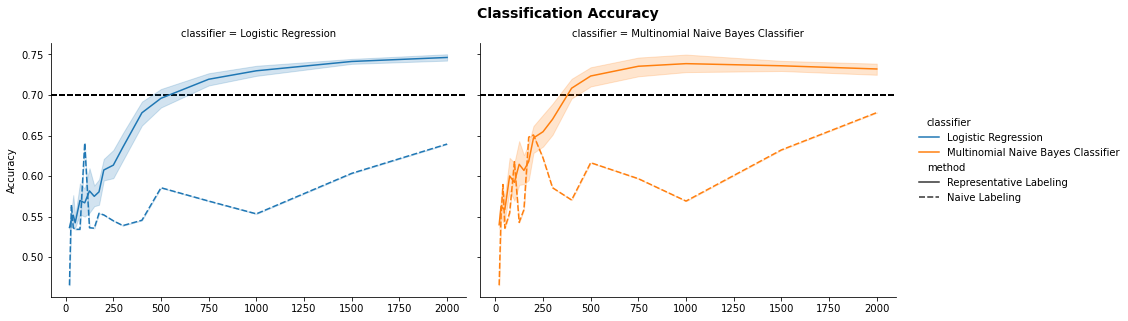

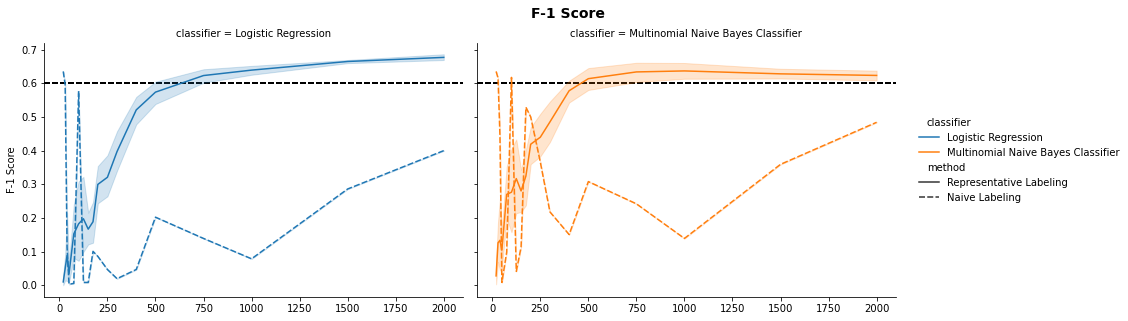

In [43]:
rp = sns.relplot(data = eval_df, x = 'k', y = 'accuracy',
                 col = 'classifier', hue = 'classifier', style = "method",
                 kind = 'line', height = 4.5, aspect = 1.4)
rp.map(plt.axhline, y = 0.7, color = "k", dashes = (3, 1), linewidth = 2, zorder = 0)
rp.set_ylabels("Accuracy")
rp.fig.subplots_adjust(top = 0.87)
rp.fig.suptitle('Classification Accuracy', size = 14, fontweight = 'bold')

rp = sns.relplot(data = eval_df, x = 'k', y = 'f1_score',
                 col = 'classifier', hue = 'classifier', style = "method",
                 kind = 'line', height = 4.5, aspect = 1.4)
rp.map(plt.axhline, y = 0.6, color = "k", dashes = (3, 1), linewidth = 2, zorder = 0)
rp.set_ylabels("F-1 Score")
rp.fig.subplots_adjust(top = 0.87)
rp.fig.suptitle('F-1 Score', size = 14, fontweight = 'bold')
plt.show()